# Unsupervised learning with a Graph-convolutional auto-encoder

## Imports and setup

In [1]:
import time
import random

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
random.seed(1)
np.random.seed(1)

### Model drawing routines

In [3]:
def plot_ξ_distribution(glk, q_model, adj, features, batches_gen):
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    x, _, feeds = next(batches_gen(q_model, features, adj, adj.shape[0], adj.shape[0], None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # KDE plots
    q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax1)
    ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ.T):
        ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Test graphs

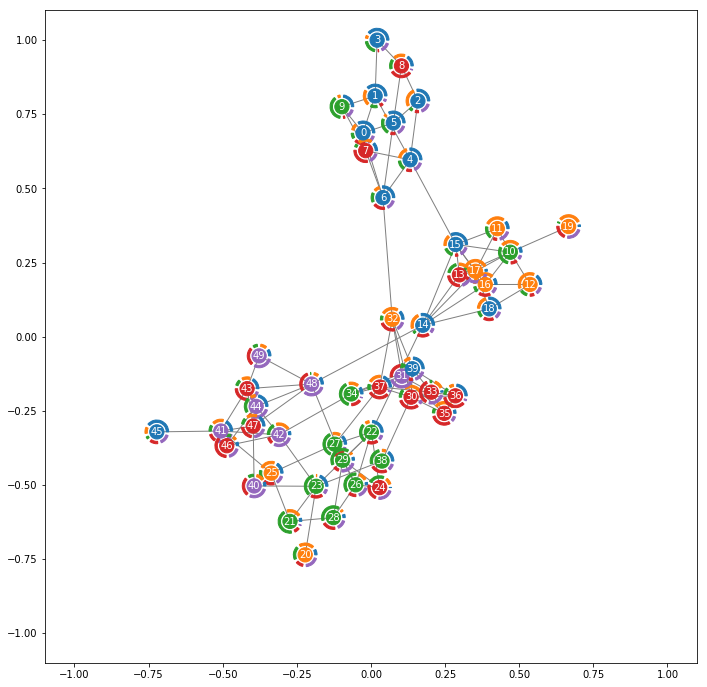

In [4]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
#features = np.random.random((l * k, l)).astype(np.float32)
features = labels + np.abs(np.random.normal(loc=0.0, scale=1.5, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

In [19]:
# Build the VAE
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

# Encoder
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)
# Decoder
p_builder = ae.build_p_builder(dims, use_bias=use_bias)

# Actual VAE
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0,  # p adj loss
        1.0,  # p v loss
    ],
)

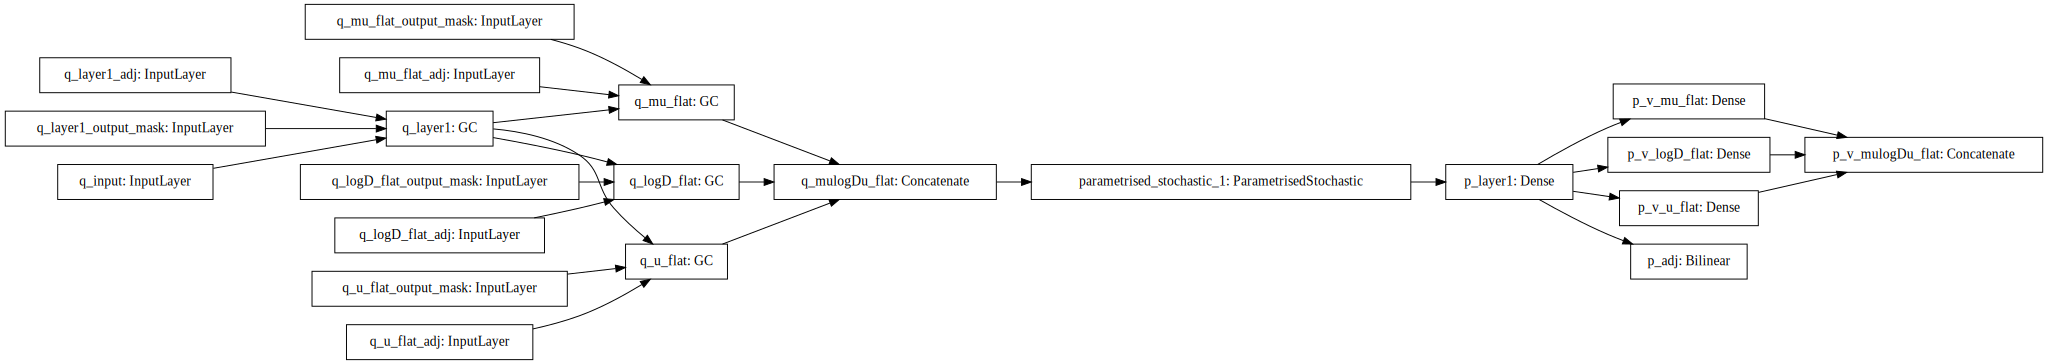

In [6]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

### Show what batch-layer adjacency matrices look like

In [7]:
#def plot_batch_feeds(batch_adj, batch_feeds):
#    fig, axes = plt.subplots(1, len(batch_feeds) + 1,
#                             subplot_kw={'aspect': 'equal'},
#                             figsize=(20, 20 / (len(batch_feeds) + 1)),
#                             tight_layout=True)
#    for i, (name, value) in enumerate(sorted(batch_feeds.items())):
#        if name.endswith('mask'):
#            axes[i].imshow(value[:, None], aspect='auto')
#            axes[i].set_aspect('equal')
#            axes[i].set_xticklabels([])
#            axes[i].set_xticks([])
#        else:
#            axes[i].imshow(value.toarray())
#        axes[i].set_title(name)
#    axes[len(batch_feeds)].imshow(batch_adj.toarray())
#    axes[len(batch_feeds)].set_title('Needed adj')

In [8]:
#for batch_needed_nodes, batch_output_nodes, batch_feeds in batching.epoch_batches(vae, adj, len(features) // 4, len(features) // 8, None):
#    plot_batch_feeds(adj[batch_needed_nodes, :][:, batch_needed_nodes], batch_feeds)

### Batches generator

In [9]:
def batches(model, features, adj, seeds_per_batch, max_walk_length, neighbour_samples=None):
    features = utils.scale_center(features)
    
    while True:
        for needed_nodes, output_nodes, feeds in batching.epoch_batches(model, adj, seeds_per_batch, max_walk_length, neighbour_samples):
            batch_adj = adj[output_nodes, :][:, output_nodes]

            x = features[needed_nodes]
            y = [
                np.zeros(1), # ignored
                utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
                utils.expand_dims_tile(features[output_nodes], 1, n_ξ_samples),
            ]
            
            yield x, y, feeds

**Before training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

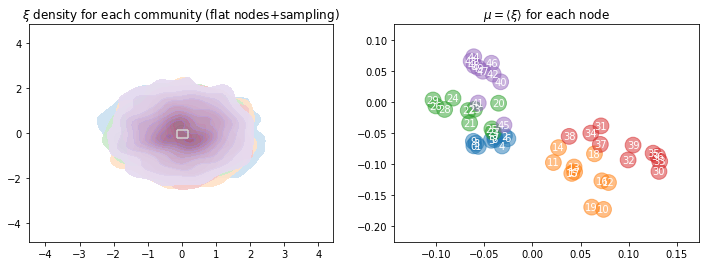

In [10]:
plot_ξ_distribution((g, l, k), q_model, adj, features, batches)

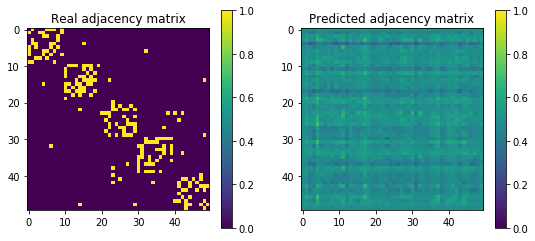

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batches(vae, features, adj, adj.shape[0], adj.shape[0], None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

**Train**

In [12]:
rm -r ./logs

rm: cannot remove './logs': No such file or directory


In [13]:
time.sleep(5)

In [20]:
n_epochs = 250
seeds_per_batch = 1 #len(features)
max_walk_length = 20

history = vae.fit_generator_feed(batches(vae, features, adj, seeds_per_batch, max_walk_length, neighbour_samples=None),
                                 steps_per_epoch=int(np.ceil(len(features) / seeds_per_batch)),
                                 epochs=n_epochs,
                                 check_array_lengths=False,
                                 shuffle=False,
                                 verbose=0,
                                 callbacks=[
                                     TQDMCallback(),
                                 ])

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

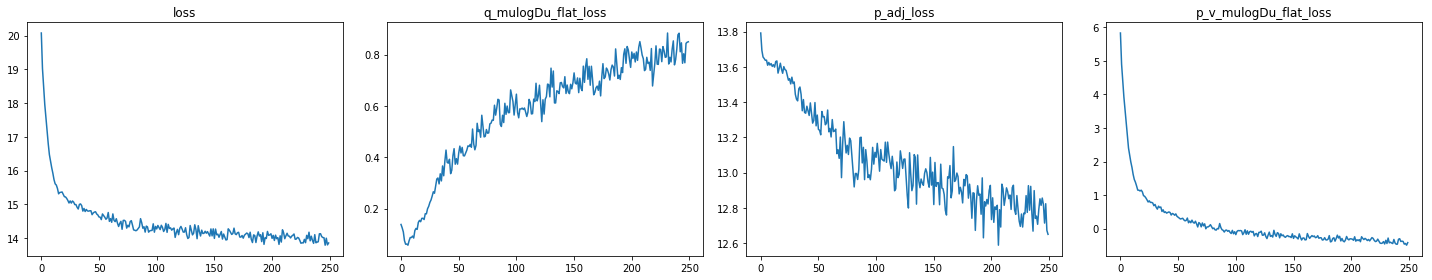

In [21]:
# overlap seeds_per_batch 1, walk_length 20, epochs 250
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

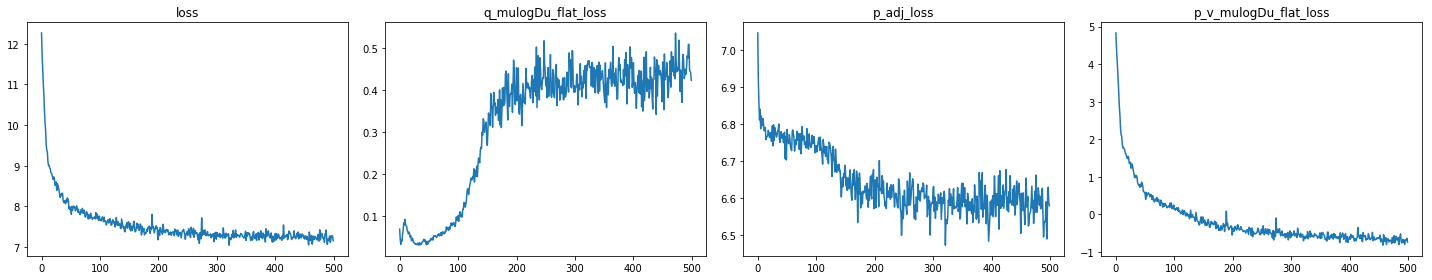

In [16]:
# overlap seeds_per_batch 1, walk_length 10, epochs 500
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

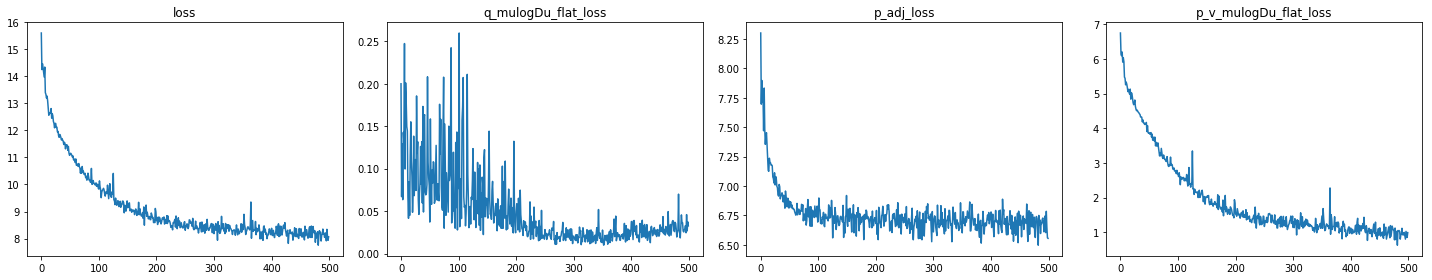

In [66]:
# 10, 10
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

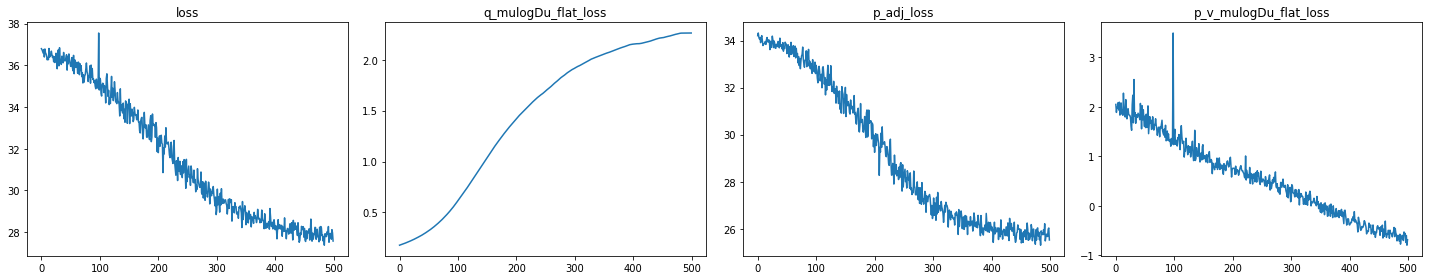

In [61]:
# 50, 10, again
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

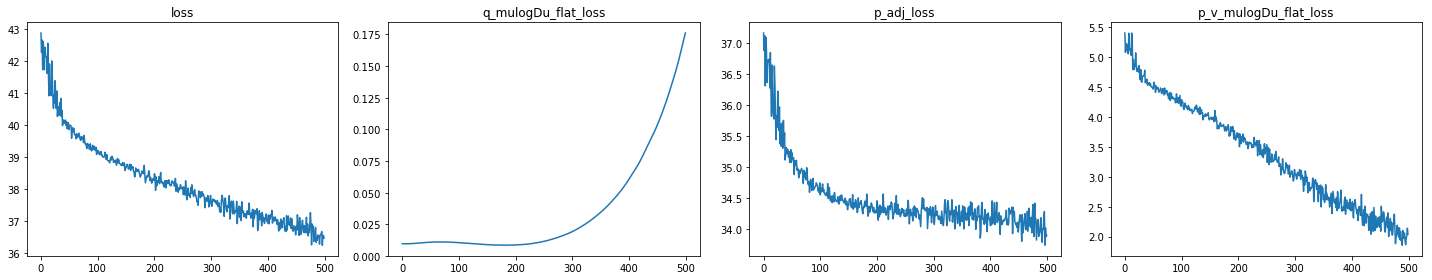

In [59]:
# 50, 10
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

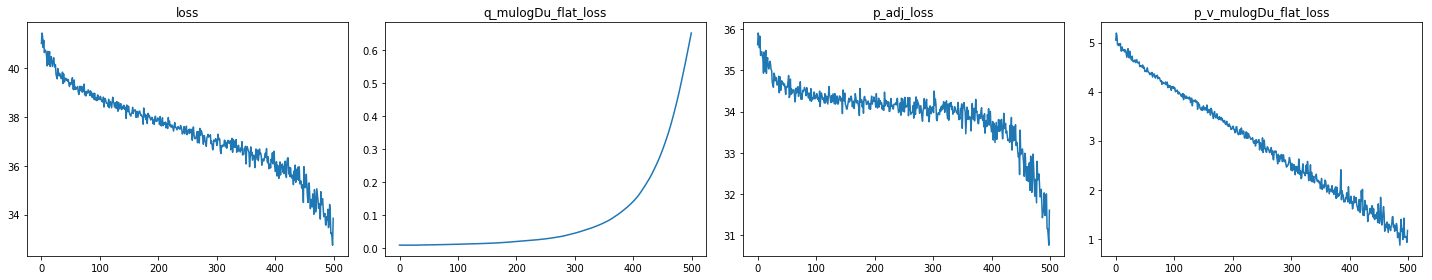

In [54]:
# 50, 50
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

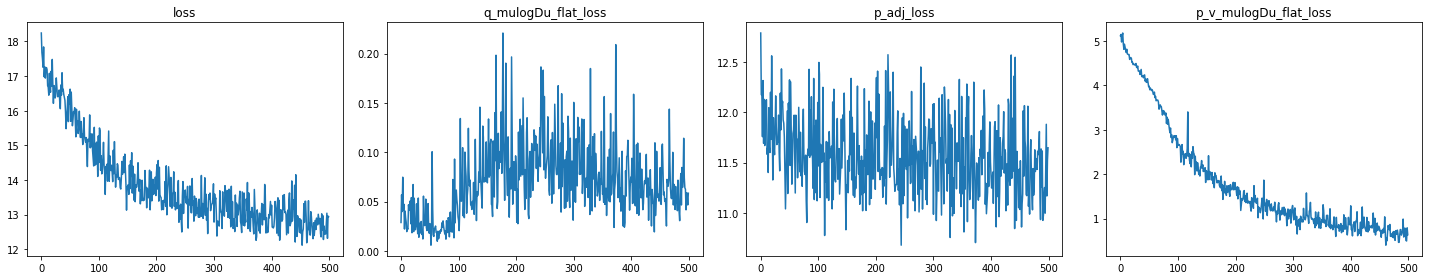

In [49]:
#20, 10
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

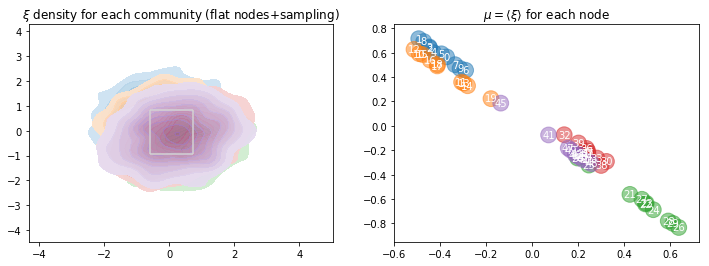

In [22]:
plot_ξ_distribution((g, l, k), q_model, adj, features, batches)

Predicted adjacency matrix:

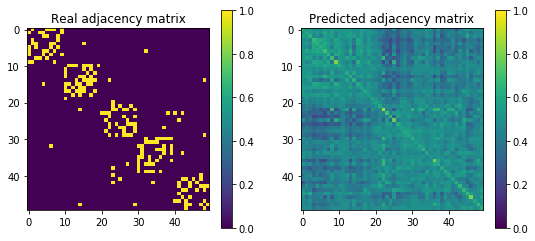

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batches(vae, features, adj, adj.shape[0], 1, None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

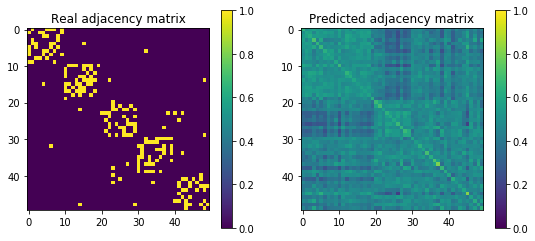

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batches(vae, features, adj, adj.shape[0], 50, None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

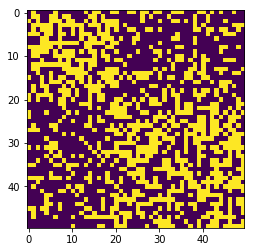

In [24]:
plt.imshow(np.random.binomial(1, scipy.special.expit(adj_pred[0].mean(axis=0))))

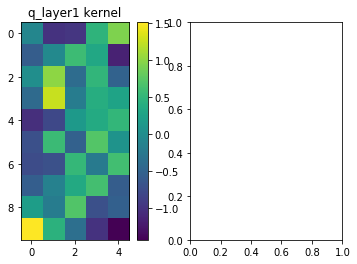

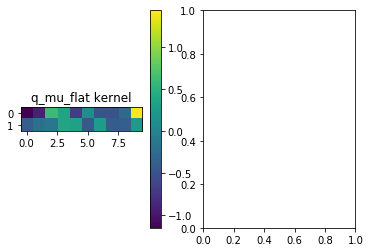

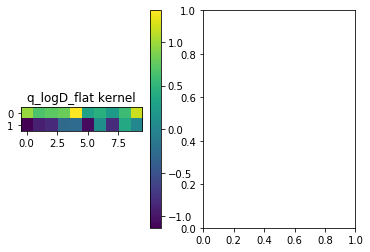

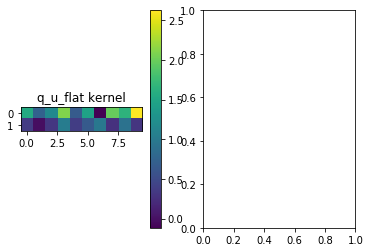

In [25]:
for layer in q_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)

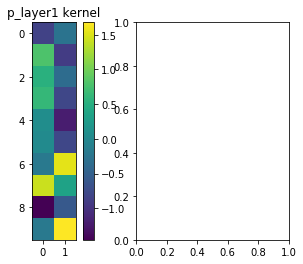

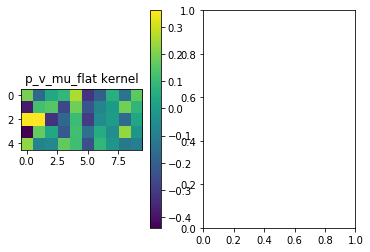

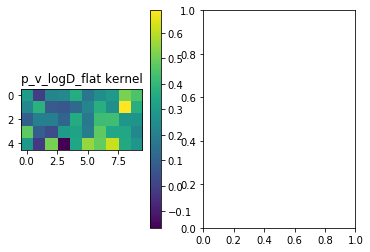

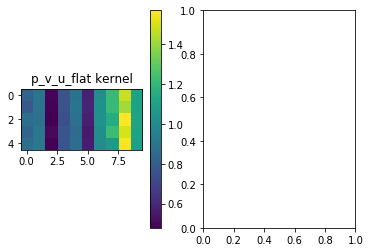

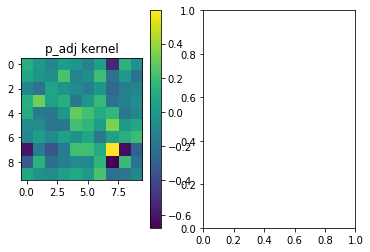

In [26]:
for layer in p_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)